## Chapter 3 U-Net 객체 분할로 인물 사진 배경 흐리게 하기

In [1]:
!pip install -q torchinfo

In [2]:
import random
import numpy as np
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")

#reading files
import os
import cv2
from PIL import Image
from torch.utils.data import Dataset, DataLoader
import albumentations as A
from albumentations.pytorch import ToTensorV2

#plots
import matplotlib.pyplot as plt

#model
import torch
from torch import nn, optim
import torchvision
from torchinfo import summary

In [3]:
is_cuda = torch.cuda.is_available()
device = torch.device("cuda" if is_cuda else "cpu")
print(is_cuda, device)

True cuda


In [4]:
seed = 130
random.seed(seed)         # python seed
np.random.seed(seed)      # numpy seed
torch.manual_seed(seed)   # torch seed
if device == 'cuda':
  torch.cuda.manual_seed_all(seed)  # gpu seed

### 3.1 데이터 분석(EG1800)

In [5]:
%cd /content/drive/MyDrive/Colab\ Notebooks/프로젝트로\ 시작하는\ Pytorch/6.3
%ls

/content/drive/MyDrive/Colab Notebooks/프로젝트로 시작하는 Pytorch/6.3
'6.3 segmentation.ipynb'   best.pth   dataset/  'EG1800 archive.zip'


In [6]:
# !unzip -qq "EG1800 archive.zip" -d dataset

In [7]:
ls dataset/EG1800

Images/  Labels/  README.md


In [8]:
ls dataset/EG1800/Images | head

00001.png
00002.png
00003.png
00004.png
00005.png
00006.png
00007.png
00008.png
00009.png
00010.png


In [9]:
ls dataset/EG1800/Labels | head

00001.png
00002.png
00003.png
00004.png
00005.png
00006.png
00007.png
00008.png
00009.png
00010.png


In [10]:
base_path = 'dataset/EG1800/'
image_path = os.path.join(base_path, 'Images')
label_path = os.path.join(base_path, 'Labels')

file_list = os.listdir(image_path)

print('Total {} images.'.format(len(file_list)))

Total 1736 images.


(-0.5, 599.5, 799.5, -0.5)

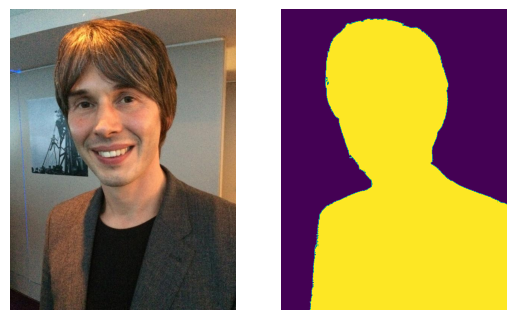

In [11]:
image_name = "00001.png"

plt.subplot(1, 2, 1)
plt.imshow(plt.imread(os.path.join(image_path, image_name)))
plt.axis("off")
plt.subplot(1, 2, 2)
plt.imshow(plt.imread(os.path.join(label_path, image_name)))
plt.axis("off")

(-0.5, 599.5, 799.5, -0.5)

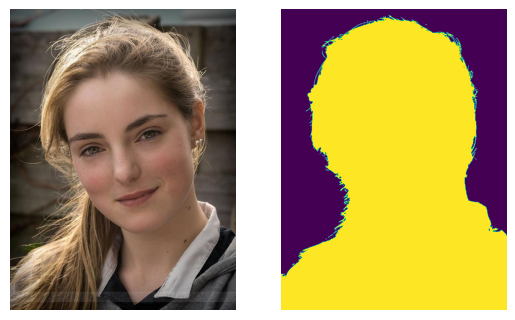

In [12]:
image_name = "00120.png"

plt.subplot(1, 2, 1)
plt.imshow(plt.imread(os.path.join(image_path, image_name)))
plt.axis("off")
plt.subplot(1, 2, 2)
plt.imshow(plt.imread(os.path.join(label_path, image_name)))
plt.axis("off")

### 3.2 데이터셋

In [13]:
class PortraitDataset(Dataset):
  def __init__(self, root_dir, transform=None):
    self.root_dir = root_dir
    self.transform=transform

    self.image_dir = os.path.join(self.root_dir, "Images")
    self.label_dir = os.path.join(self.root_dir, "Labels")
    self.file_list = os.listdir(self.image_dir)

  def __getitem__(self, idx):
    file_name = self.file_list[idx]
    image_path = os.path.join(self.image_dir, file_name)
    label_path = os.path.join(self.label_dir, file_name)

    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    mask = cv2.imread(label_path, cv2.IMREAD_GRAYSCALE)

    if self.transform:
      augs = self.transform(image=image, mask=mask)

      image = augs['image']
      mask = augs['mask']

    return image, mask.unsqueeze(0)

  def __len__(self):
    return len(self.file_list)

In [14]:
train_transform=A.Compose(
  [
      A.Resize(height=224, width=224),
      A.HorizontalFlip(p=0.5),
      A.VerticalFlip(p=0.1),
      A.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225]),
      ToTensorV2()
  ],
)

test_transform=A.Compose(
  [
    A.Resize(height=224, width=224),
    A.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225]),
    ToTensorV2(),
  ],
)

In [15]:
portrait_dataset = PortraitDataset(base_path, train_transform)

data_loader = DataLoader(portrait_dataset, batch_size=1,
                        shuffle=True, num_workers=0)

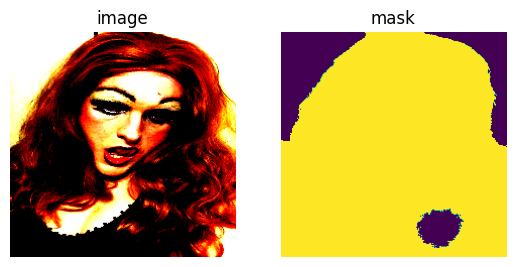

In [16]:
for image, target in data_loader:
  img = np.transpose(image[0].numpy(), (1, 2, 0))
  target = target[0].squeeze().numpy()

  # display the image
  plt.subplot(1,2,1)
  plt.imshow(img)
  plt.axis('off')
  plt.title("image")
  plt.subplot(1,2,2)
  plt.imshow(target)
  plt.axis('off')
  plt.title("mask")

  break

In [17]:
def get_dataset(
    root, train=0.8, val=0.1,
    train_transforms=None, test_transforms=None,
    random_seed=130
):
  origin = PortraitDataset(
    root,
    transform=train_transforms
  )

  train_samples = int(len(origin) * train)
  val_samples = int(len(origin) * val)
  test_samples = len(origin) - train_samples - val_samples

  torch.manual_seed(random_seed)
  trainset, valset, testset = torch.utils.data.random_split(
    origin,
    (train_samples, val_samples, test_samples),
  )
  valset.transforms = test_transforms
  testset.transforms = test_transforms

  return trainset, valset, testset

trainset, valset, testset = get_dataset(base_path,
                                        train_transforms=train_transform,
                                        test_transforms=test_transform)
print(len(trainset), len(valset), len(testset))

1388 173 175


### 3.3 U-Net 모델

In [18]:
def conv_bn_relu(in_channels, out_channels, kernel_size=3, stride=1, padding=1):
  conv = nn.Conv2d(in_channels=in_channels, out_channels=out_channels,
                   kernel_size=kernel_size, stride=stride, padding=padding)
  bn = nn.BatchNorm2d(out_channels)
  relu = nn.ReLU()
  return nn.Sequential(conv, bn, relu)

In [19]:
class EncBlock(nn.Module):
  def __init__(self, in_channels, out_channels):
    super(EncBlock, self).__init__()
    self.conv1 = conv_bn_relu(in_channels, out_channels)
    self.conv2 = conv_bn_relu(out_channels, out_channels)

  def forward(self, x):
    x = self.conv1(x)
    x = self.conv2(x)
    return x

In [20]:
class DecBlock(nn.Module):
  def __init__(self, in_channels, out_channels, hidden_dims):
    super(DecBlock, self).__init__()
    self.conv1 = conv_bn_relu(in_channels, hidden_dims)
    self.conv2 = conv_bn_relu(hidden_dims, out_channels)

  def forward(self, x1, x2):
    x = torch.cat((x1, x2), dim=1)
    x = self.conv1(x)
    x = self.conv2(x)
    return x

In [21]:
class Encoder(nn.Module):
  def __init__(self):
    super(Encoder, self).__init__()
    self.enc1 = EncBlock(3, 64)
    self.enc2 = EncBlock(64, 128)
    self.enc3 = EncBlock(128, 256)
    self.enc4 = EncBlock(256, 512)
    self.enc5 = conv_bn_relu(512, 1024)
    self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

  def forward(self, x):
    enc1 = self.enc1(x)
    enc2 = self.enc2(self.pool(enc1))
    enc3 = self.enc3(self.pool(enc2))
    enc4 = self.enc4(self.pool(enc3))
    enc5 = self.enc5(self.pool(enc4))
    return [enc5, enc4, enc3, enc2, enc1]

In [22]:
class Decoder(nn.Module):
  def __init__(self):
    super(Decoder, self).__init__()
    self.dec5 = conv_bn_relu(1024, 512)
    self.dec4 = DecBlock(1024, 256, 512)
    self.dec3 = DecBlock(512, 128, 256)
    self.dec2 = DecBlock(256, 64, 128)
    self.dec1 = DecBlock(128, 64, 64)

    self.unpool4 = nn.ConvTranspose2d(512, 512, kernel_size=2, stride=2)
    self.unpool3 = nn.ConvTranspose2d(256, 256, kernel_size=2, stride=2)
    self.unpool2 = nn.ConvTranspose2d(128, 128, kernel_size=2, stride=2)
    self.unpool1 = nn.ConvTranspose2d(64, 64, kernel_size=2, stride=2)

  def forward(self, x):
    dec5 = self.dec5(x[0])

    unpool4 = self.unpool4(dec5)
    dec4 = self.dec4(x[1], unpool4)

    unpool3 = self.unpool3(dec4)
    dec3 = self.dec3(x[2], unpool3)

    unpool2 = self.unpool2(dec3)
    dec2 = self.dec2(x[3], unpool2)

    unpool1 = self.unpool1(dec2)
    dec1 = self.dec1(x[4], unpool1)
    return dec1

In [23]:
class UNet(nn.Module):
  def __init__(self):
    super(UNet, self).__init__()
    self.encoder = Encoder()
    self.decoder = Decoder()
    self.fc = nn.Conv2d(64, 1, kernel_size=1)

  def forward(self, x):
    x = self.encoder(x)
    x = self.decoder(x)
    x = self.fc(x)
    return x

In [24]:
model = UNet()
summary(model, (1, 3, 224, 224))

Layer (type:depth-idx)                   Output Shape              Param #
UNet                                     [1, 1, 224, 224]          --
├─Encoder: 1-1                           [1, 1024, 14, 14]         --
│    └─EncBlock: 2-1                     [1, 64, 224, 224]         --
│    │    └─Sequential: 3-1              [1, 64, 224, 224]         1,920
│    │    └─Sequential: 3-2              [1, 64, 224, 224]         37,056
│    └─MaxPool2d: 2-2                    [1, 64, 112, 112]         --
│    └─EncBlock: 2-3                     [1, 128, 112, 112]        --
│    │    └─Sequential: 3-3              [1, 128, 112, 112]        74,112
│    │    └─Sequential: 3-4              [1, 128, 112, 112]        147,840
│    └─MaxPool2d: 2-4                    [1, 128, 56, 56]          --
│    └─EncBlock: 2-5                     [1, 256, 56, 56]          --
│    │    └─Sequential: 3-5              [1, 256, 56, 56]          295,680
│    │    └─Sequential: 3-6              [1, 256, 56, 56]       

### 3.4 모델 학습

In [25]:
def train(model, dataloader, criterion, optimizer, epoch, device):
  model.train()

  running_loss = 0

  with tqdm(dataloader) as pbar:
    for i, (images, targets) in enumerate(pbar):
      images = images.to(device)
      targets = targets.type(torch.FloatTensor).to(device)

      optimizer.zero_grad()

      outputs = model(images)
      loss = criterion(outputs.squeeze(), targets.squeeze())

      loss.backward()
      optimizer.step()

      running_loss += loss.item()
      pbar.set_postfix(loss=loss.item())

  return running_loss/len(dataloader)

In [26]:
def validation(model, dataloader, criterion, epoch, device):
  model.eval()

  running_loss = 0.
  with tqdm(dataloader) as pbar:
    with torch.no_grad():
      for i, (images, targets) in enumerate(pbar):
        images = images.to(device)
        targets = targets.type(torch.FloatTensor).to(device)

        outputs = model(images)
        loss = criterion(outputs.squeeze(), targets.squeeze())

        running_loss += loss.item()
        pbar.set_postfix(loss=loss.item())

  print(f'[{epoch}/{EPOCH}] valid loss: {running_loss/len(dataloader):.4f}\n')

  return running_loss/len(dataloader)

In [ ]:
EPOCH = 10
BATCH_SIZE = 32
NUM_WORKERS = 2
LR = 0.001

train_transform=A.Compose(
  [
      A.Resize(height=224, width=224),
      A.HorizontalFlip(p=0.5),
      A.VerticalFlip(p=0.1),
      A.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225]),
      ToTensorV2()
  ],
)

test_transform=A.Compose(
  [
    A.Resize(height=224, width=224),
    A.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225]),
    ToTensorV2(),
  ],
)

trainset, valset, testset = get_dataset(base_path,
                                        train_transforms=train_transform,
                                        test_transforms=test_transform
                                       )

train_loader = DataLoader(
  dataset=trainset, shuffle=True,
  batch_size=BATCH_SIZE, num_workers=NUM_WORKERS,
)
val_loader = DataLoader(
  dataset=valset,
  batch_size=BATCH_SIZE, num_workers=NUM_WORKERS,
)

# Model
model = UNet()

# Optimizer, Loss, Scheduler
optimizer = optim.Adam(model.parameters(), lr=LR)
criterion = nn.BCEWithLogitsLoss()
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.5)

model = model.to(device)
criterion = criterion.to(device)

# Start Training
min_loss = 999
for epoch in range(EPOCH):
  print("LR:", scheduler.get_last_lr())

  tloss = train(model, train_loader, criterion, optimizer, epoch, device)
  vloss = validation(model, val_loader, criterion, epoch, device)
  scheduler.step()

  if vloss < min_loss:
    print(f"Update Best Model: {vloss}")
    torch.save(model.state_dict(), "best.pth")
    min_loss = vloss

LR: [0.001]


100%|██████████| 6/6 [00:16<00:00,  2.81s/it, loss=0.377]


[0/10] valid loss: 0.4603

Update Best Model: 0.460276981194814
LR: [0.001]


100%|██████████| 6/6 [00:05<00:00,  1.17it/s, loss=0.431]


[1/10] valid loss: 0.4593

Update Best Model: 0.45929713547229767
LR: [0.001]


100%|██████████| 6/6 [00:06<00:00,  1.09s/it, loss=0.299]


[2/10] valid loss: 0.4038

Update Best Model: 0.40383689602216083
LR: [0.0005]


100%|██████████| 6/6 [00:05<00:00,  1.12it/s, loss=0.254]


[3/10] valid loss: 0.3031

Update Best Model: 0.3030502150456111
LR: [0.0005]


100%|██████████| 6/6 [00:03<00:00,  1.60it/s, loss=0.276]


[4/10] valid loss: 0.3226

LR: [0.0005]


100%|██████████| 6/6 [00:06<00:00,  1.09s/it, loss=0.234]


[5/10] valid loss: 0.2661

Update Best Model: 0.2660772278904915
LR: [0.00025]


100%|██████████| 6/6 [00:05<00:00,  1.10it/s, loss=0.216]


[6/10] valid loss: 0.2633

Update Best Model: 0.26326506088177365
LR: [0.00025]


100%|██████████| 6/6 [00:04<00:00,  1.35it/s, loss=0.31]


[7/10] valid loss: 0.2610

Update Best Model: 0.26101743678251904
LR: [0.00025]


100%|██████████| 6/6 [00:03<00:00,  1.58it/s, loss=0.182]


[8/10] valid loss: 0.2331

Update Best Model: 0.23307958245277405
LR: [0.000125]


100%|██████████| 6/6 [00:07<00:00,  1.22s/it, loss=0.203]

[9/10] valid loss: 0.2386



torch.Size([3, 224, 224]) torch.Size([1, 224, 224])


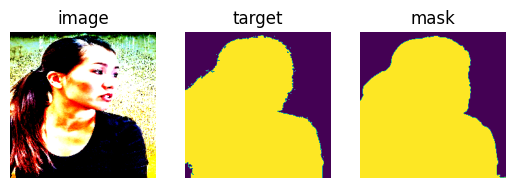

In [28]:
model = UNet()
# load best model
model.load_state_dict(torch.load("best.pth"))
model.eval()

with torch.no_grad():
  image, target = testset[0]
  print(image.shape, target.shape)

  output = model(image.unsqueeze(0))
  sigmoid_output = torch.sigmoid(output)  # Apply sigmoid activation

  mask = sigmoid_output > 0.5

  plt.subplot(1, 3, 1)
  plt.imshow(image.permute((1, 2, 0)))
  plt.title("image")
  plt.axis("off")
  plt.subplot(1, 3, 2)
  plt.imshow(target.squeeze())
  plt.title("target")
  plt.axis("off")
  plt.subplot(1, 3, 3)
  plt.imshow(mask.squeeze())
  plt.title("mask")
  plt.axis("off")

### 3.5 추론 및 배경 흐리게 처리하기

In [29]:
def inference(image):
  model = UNet()
  # load best model
  model.load_state_dict(torch.load("best.pth"))
  model.eval()

  test_transform=A.Compose(
    [
      A.Resize(height=224, width=224),
      A.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225]),
      ToTensorV2(),
    ],
  )
  image = test_transform(image=image)["image"]

  output = model(image.unsqueeze(0))
  sigmoid_output = torch.sigmoid(output)  # Apply sigmoid activation

  mask = sigmoid_output > 0.5
  return mask.squeeze()

(-0.5, 599.5, 799.5, -0.5)

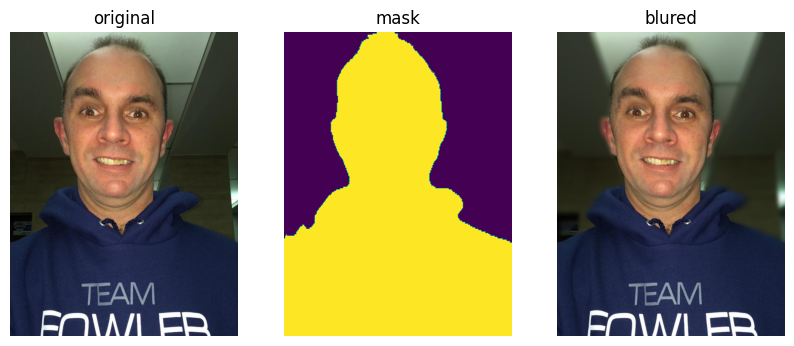

In [51]:
image_path = 'dataset/EG1800/Images/00131.png'
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

mask = inference(image).numpy().astype(np.uint8)
mask = cv2.resize(mask, (image.shape[1], image.shape[0]))

radius = 31
blur = image.copy()
for i in range(3):
  blur[:, :, i] = np.where(mask == 0,
                           cv2.GaussianBlur(blur[:, :, i], (radius, radius), 0),
                           blur[:, :, i])


plt.figure(figsize=(10, 5))

plt.subplot(1, 3, 1)
plt.imshow(image)
plt.title("original")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.imshow(mask)
plt.title("mask")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.imshow(blur)
plt.title("blured")
plt.axis("off")